<a href="https://colab.research.google.com/github/EderBraz/Applied-Data-Science-Capstone/blob/master/Capstone_Project_Brazilian_Steakhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Opening a new Steakhouse in NYC

My client, a successful restaurant chain in Brazil is looking to expand in New York. They want to create a Brazilian steakhouse restaurant. However, he does not know in which neighborhood the restaurant would gain the most attention from customers and face the least competition from other steakhouses.

####Import Libraries

In [77]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


####Download and load Data

In [78]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

####Transform the data into a pandas dataframe





In [79]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)


In [80]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [81]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [82]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


####Using geopy library to get the latitude and longitude values of New York City


In [83]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


####Creating a map of New York with neighborhoods superimposed on top



In [84]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

####Define Foursquare Credentials and Version


In [85]:
CLIENT_ID = '31MDLORI4LHK5OJKCO1VXAXW1Q50NMOFUQCDDQFGZ4LD1GU1'
CLIENT_SECRET = 'IK3FIEQPB44GYZ0FPUGH0DFH32PAQNTBSTV14IW24ZVR5Q0V' 
VERSION = '20200520' 


####Explore Neighborhoods in New York


In [86]:
 def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
"""radius = 500
LIMIT = 100
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )"""

"radius = 500\nLIMIT = 100\nnewyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],\n                                   latitudes=neighborhoods['Latitude'],\n                                   longitudes=neighborhoods['Longitude']\n                                  )"

In [88]:
url = "https://raw.githubusercontent.com/EderBraz/Coursera_Capstone/master/foursquare.csv"
newyork_venues = pd.read_csv(url)
del newyork_venues['Unnamed: 0']

In [89]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Let's find out how many unique categories can be curated from all the returned venues


In [90]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))


There are 424 uniques categories.


####Analyze Each Neighborhood in New York


In [91]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
newyork_onehot
# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,O

####Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [92]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,O

####Let's print each neighborhood along with the top 5 most common venues


In [93]:
newyork_grouped.shape

(301, 424)

In [94]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0         Pizza Place  0.13
1       Deli / Bodega  0.10
2  Chinese Restaurant  0.07
3         Supermarket  0.07
4            Pharmacy  0.03


----Annadale----
                 venue  freq
0          Pizza Place  0.20
1  American Restaurant  0.13
2        Deli / Bodega  0.07
3           Restaurant  0.07
4                 Park  0.07


----Arden Heights----
           venue  freq
0       Pharmacy  0.25
1  Deli / Bodega  0.25
2    Coffee Shop  0.25
3    Pizza Place  0.25
4    Yoga Studio  0.00


----Arlington----
                 venue  freq
0        Deli / Bodega   0.2
1  American Restaurant   0.2
2         Home Service   0.2
3          Coffee Shop   0.2
4             Bus Stop   0.2


----Arrochar----
                      venue  freq
0                  Bus Stop  0.10
1             Deli / Bodega  0.10
2        Italian Restaurant  0.10
3                Bagel Shop  0.10
4  Mediterranean Restaurant  0.05


----Arverne----
            venue  freq
0

####Sort the venues in descending order.



In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

####Creating new dataframe to display the top 10 venues for each neighborhood.

In [96]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Check Cashing Service,Smoke Shop,Gas Station,Martial Arts Dojo,Pharmacy,Grocery Store
1,Annadale,Pizza Place,American Restaurant,Bakery,Food,Sushi Restaurant,Park,Liquor Store,Train Station,Restaurant,Diner
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Pizza Place,Women's Store,Filipino Restaurant,Event Service,Event Space,Exhibit,Factory
3,Arlington,Deli / Bodega,American Restaurant,Coffee Shop,Bus Stop,Home Service,Women's Store,Filipino Restaurant,Event Service,Event Space,Exhibit
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Bagel Shop,Food Truck,Mediterranean Restaurant,Sporting Goods Shop,Middle Eastern Restaurant,Sandwich Place,Pharmacy
5,Arverne,Surf Spot,Metro Station,Sandwich Place,Thai Restaurant,Pizza Place,Coffee Shop,Donut Shop,Board Shop,Bed & Breakfast,Bus Stop
6,Astoria,Middle Eastern Restaurant,Bar,Hookah Bar,Greek Restaurant,Indian Restaurant,Deli / Bodega,Mediterranean Restaurant,Bakery,Seafood Restaurant,Gourmet Shop
7,Astoria Heights,Pizza Place,Hostel,Italian Restaurant,Burger Joint,Shopping Mall,Plaza,Playground,Bus Station,Cocktail Bar,Bowling Alley
8,Auburndale,Bar,Supermarket,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Toy / Game Store,Pharmacy,Sushi Restaurant,Mobile Phone Shop,Athletics & Sports
9,Bath Beach,Pharmacy,Chinese Restaurant,Gas Station,Sushi Restaurant,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Russian Restaurant,Surf Spot,Mobile Phone Shop


In [97]:
newyork_steakhouse = newyork_grouped[["Neighborhood", "Steakhouse"]]
newyork_steakhouse.head()


,Neighborhood,Steakhouse
0,Allerton,0.0
1,Annadale,0.0
2,Arden Heights,0.0
3,Arlington,0.0
4,Arrochar,0.0


In [98]:
newyork_steakhouse_merged = pd.merge(neighborhoods, newyork_steakhouse, on='Neighborhood')
newyork_steakhouse_merged = newyork_steakhouse_merged.reindex(columns=['Borough','Neighborhood','Steakhouse','Latitude','Longitude'])
newyork_steakhouse_merged.head()

,Borough,Neighborhood,Steakhouse,Latitude,Longitude
0,Bronx,Wakefield,0.0,40.894705,-73.847201
1,Bronx,Co-op City,0.0,40.874294,-73.829939
2,Bronx,Eastchester,0.0,40.887556,-73.827806
3,Bronx,Fieldston,0.0,40.895437,-73.905643
4,Bronx,Riverdale,0.0,40.890834,-73.912585


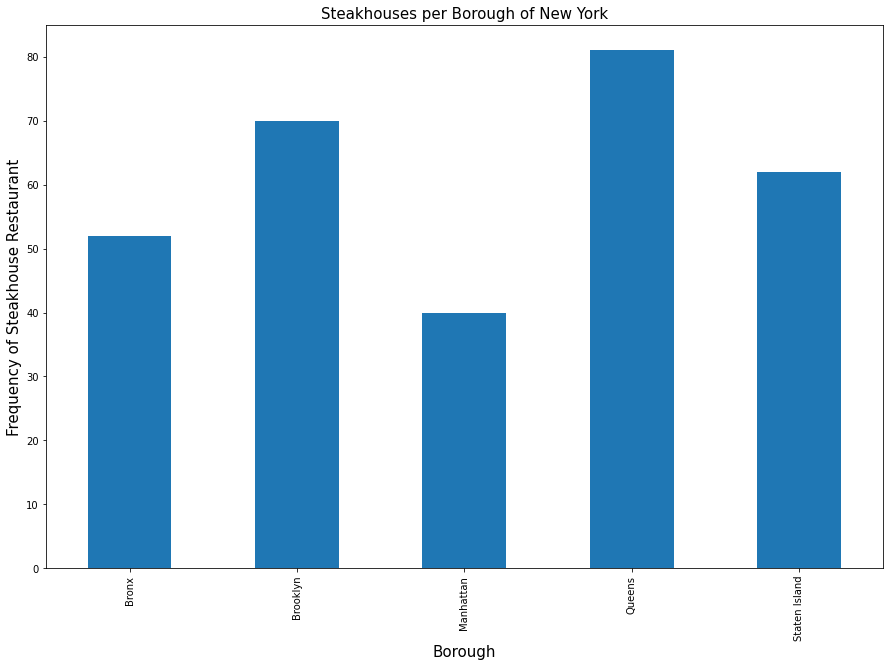

In [99]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,10))
plt.title('Steakhouses per Borough of New York', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Steakhouse Restaurant", fontsize=15)
newyork_steakhouse_merged.groupby('Borough')['Steakhouse'].count().plot(kind='bar')
plt.show()

####Determine the optimal number of clusters for k-means clustering





The technique to determine K(number of clusters) is called the elbow method.


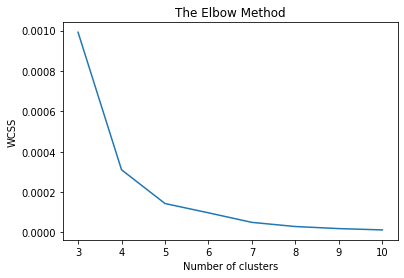

In [100]:
wcss = []
X = newyork_steakhouse.drop('Neighborhood', 1)
for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

####Cluster Neighborhoods in New York


In [101]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

###Results

Let's create a new dataframe that includes the cluster labels as well as the top 10 venues for each neighborhood.



In [102]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
newyork_merged = neighborhoods
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head(10)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0.0,Pharmacy,Ice Cream Shop,Donut Shop,Sandwich Place,Gas Station,Dessert Shop,Laundromat,Falafel Restaurant,Field,Factory
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Fast Food Restaurant,Bus Station,Pizza Place,Discount Store,Pharmacy,Mattress Store,Liquor Store,Bagel Shop,Restaurant,Salon / Barbershop
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Caribbean Restaurant,Deli / Bodega,Diner,Seafood Restaurant,Pizza Place,Metro Station,Bakery,Fast Food Restaurant,Donut Shop,Bus Stop
3,Bronx,Fieldston,40.895437,-73.905643,0.0,River,Bus Station,Plaza,Women's Store,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory
4,Bronx,Riverdale,40.890834,-73.912585,0.0,Bus Station,Park,Plaza,Gym,Playground,Bank,Food Truck,Home Service,Exhibit,Factory
5,Bronx,Kingsbridge,40.881687,-73.902818,0.0,Pizza Place,Bar,Supermarket,Latin American Restaurant,Mexican Restaurant,Sandwich Place,Deli / Bodega,Bakery,Spanish Restaurant,Fried Chicken Joint
6,Manhattan,Marble Hill,40.876551,-73.910660,1.0,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Video Game Store,Supplement Shop,Bank,Donut Shop,Pharmacy,Kids Store
7,Bronx,Woodlawn,40.898273,-73.867315,0.0,Deli / Bodega,Pizza Place,Pub,Playground,Food Truck,Grocery Store,Park,Bar,Bakery,Liquor Store
8,Bronx,Norwood,40.877224,-73.879391,0.0,Pizza Place,Park,Bank,Pharmacy,Supermarket,Restaurant,Coffee Shop,Mobile Phone Shop,Liquor Store,Pet Store
9,Bronx,Williamsbridge,40.881039,-73.857446,0.0,Bar,Nightclub,Caribbean Restaurant,Soup Place,Women's Store,Filipino Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant


In [103]:
# add clustering labels
newyork_steakhouse_cluster = newyork_steakhouse.copy()
newyork_steakhouse_cluster["Cluster Labels"] = kmeans.labels_
newyork_steakhouse_cluster.head()

,Neighborhood,Steakhouse,Cluster Labels
0,Allerton,0.0,0
1,Annadale,0.0,0
2,Arden Heights,0.0,0
3,Arlington,0.0,0
4,Arrochar,0.0,0


In [104]:
newyork_steakhouse_cluster_merged = pd.merge(neighborhoods, newyork_steakhouse_cluster[['Neighborhood','Steakhouse', 'Cluster Labels']], on='Neighborhood')
newyork_steakhouse_cluster_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
0,Bronx,Wakefield,40.894705,-73.847201,0.0,0
1,Bronx,Co-op City,40.874294,-73.829939,0.0,0
2,Bronx,Eastchester,40.887556,-73.827806,0.0,0
3,Bronx,Fieldston,40.895437,-73.905643,0.0,0
4,Bronx,Riverdale,40.890834,-73.912585,0.0,0


In [105]:
newyork_steakhouse_cluster_merged.sort_values(["Cluster Labels"], inplace=True)
newyork_steakhouse_cluster_merged

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
0,Bronx,Wakefield,40.894705,-73.847201,0.000000,0
205,Staten Island,Grymes Hill,40.624185,-74.087248,0.000000,0
204,Staten Island,West Brighton,40.631879,-74.107182,0.000000,0
203,Staten Island,Rosebank,40.615305,-74.069805,0.000000,0
202,Staten Island,Stapleton,40.626928,-74.077902,0.000000,0
201,Staten Island,New Brighton,40.640615,-74.087017,0.000000,0
199,Queens,Forest Hills Gardens,40.714611,-73.841022,0.000000,0
206,Staten Island,Todt Hill,40.597069,-74.111329,0.000000,0
198,Queens,North Corona,40.754071,-73.857518,0.000000,0
196,Queens,Brookville,40.660003,-73.751753,0.000000,0


let's visualize the resulting clusters

In [106]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(newyork_steakhouse_cluster_merged['Latitude'], newyork_steakhouse_cluster_merged['Longitude'], newyork_steakhouse_cluster_merged['Neighborhood'], newyork_steakhouse_cluster_merged['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

###Examining Clusters


####Cluster 1

In [107]:
newyork_steakhouse_cluster1 = newyork_steakhouse_cluster_merged.loc[newyork_steakhouse_cluster_merged['Cluster Labels'] == 0]
newyork_steakhouse_cluster1.head(10)

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
0,Bronx,Wakefield,40.894705,-73.847201,0.0,0
205,Staten Island,Grymes Hill,40.624185,-74.087248,0.0,0
204,Staten Island,West Brighton,40.631879,-74.107182,0.0,0
203,Staten Island,Rosebank,40.615305,-74.069805,0.0,0
202,Staten Island,Stapleton,40.626928,-74.077902,0.0,0
201,Staten Island,New Brighton,40.640615,-74.087017,0.0,0
199,Queens,Forest Hills Gardens,40.714611,-73.841022,0.0,0
206,Staten Island,Todt Hill,40.597069,-74.111329,0.0,0
198,Queens,North Corona,40.754071,-73.857518,0.0,0
196,Queens,Brookville,40.660003,-73.751753,0.0,0


In [108]:
newyork_merged1 = newyork_merged.loc[newyork_merged['Cluster Labels']== 0]
newyork_best_places = newyork_merged1[newyork_merged1['1st Most Common Venue'].str.contains("Restaurant")]
newyork_best_places.shape

(65, 15)

####Cluster 2

In [109]:
newyork_steakhouse_cluster2 = newyork_steakhouse_cluster_merged.loc[newyork_steakhouse_cluster_merged['Cluster Labels'] == 1]
newyork_steakhouse_cluster2

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
6,Manhattan,Marble Hill,40.876551,-73.910660,0.038462,1
53,Brooklyn,Manhattan Terrace,40.614433,-73.957438,0.040000,1
192,Queens,Lefrak City,40.736075,-73.862525,0.040000,1
194,Queens,Rockaway Park,40.580343,-73.841534,0.041667,1
98,Brooklyn,Ocean Parkway,40.613060,-73.968367,0.047619,1


In [110]:
newyork_merged2 = newyork_merged.loc[newyork_merged['Cluster Labels']== 1]
newyork_merged2

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Manhattan,Marble Hill,40.876551,-73.910660,1.0,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Video Game Store,Supplement Shop,Bank,Donut Shop,Pharmacy,Kids Store
53,Brooklyn,Manhattan Terrace,40.614433,-73.957438,1.0,Donut Shop,Pizza Place,Ice Cream Shop,Convenience Store,Coffee Shop,Eastern European Restaurant,Pharmacy,Organic Grocery,Bagel Shop,Bakery
98,Brooklyn,Ocean Parkway,40.613060,-73.968367,1.0,Donut Shop,Gym,Sake Bar,Eastern European Restaurant,Pharmacy,General Entertainment,Paper / Office Supplies Store,Home Service,Restaurant,Liquor Store
189,Queens,Lefrak City,40.736075,-73.862525,1.0,Department Store,Cosmetics Shop,Bakery,Women's Store,Fruit & Vegetable Store,Bank,Mexican Restaurant,Supermarket,Furniture / Home Store,Steakhouse
191,Queens,Rockaway Park,40.580343,-73.841534,1.0,Beach,Pizza Place,Donut Shop,Pharmacy,Steakhouse,Seafood Restaurant,Bar,Bank,Bagel Shop,Sandwich Place


####Cluster 3

In [111]:
newyork_steakhouse_cluster3 = newyork_steakhouse_cluster_merged.loc[newyork_steakhouse_cluster_merged['Cluster Labels'] == 2]
newyork_steakhouse_cluster3

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
130,Manhattan,Financial District,40.707107,-74.010665,0.030000,2
61,Brooklyn,Williamsburg,40.707144,-73.958115,0.028571,2
125,Manhattan,West Village,40.734434,-74.006180,0.020000,2
152,Queens,College Point,40.784903,-73.843045,0.026316,2
115,Manhattan,Murray Hill,40.748303,-73.978332,0.024194,2
106,Manhattan,East Harlem,40.792249,-73.944182,0.023810,2
99,Brooklyn,Fort Hamilton,40.614768,-74.031979,0.028571,2
270,Manhattan,Sutton Place,40.760280,-73.963556,0.020619,2
178,Queens,Bay Terrace,40.782843,-73.776802,0.020833,2
179,Staten Island,Bay Terrace,40.553988,-74.139166,0.020833,2


In [112]:
newyork_merged3 = newyork_merged.loc[newyork_merged['Cluster Labels']== 2]
newyork_merged3

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Brooklyn,Williamsburg,40.707144,-73.958115,2.0,Coffee Shop,Bagel Shop,Bar,Yoga Studio,Latin American Restaurant,Liquor Store,Clothing Store,Gym,Tapas Restaurant,Grocery Store
99,Brooklyn,Fort Hamilton,40.614768,-74.031979,2.0,Gym / Fitness Center,Pharmacy,Bus Stop,Sandwich Place,Chinese Restaurant,Cocktail Bar,Lounge,Bank,Bagel Shop,Steakhouse
106,Manhattan,East Harlem,40.792249,-73.944182,2.0,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Grocery Store,Park,Cocktail Bar,Liquor Store,Sandwich Place
113,Manhattan,Clinton,40.759101,-73.996119,2.0,Theater,Coffee Shop,Gym / Fitness Center,Hotel,Gym,American Restaurant,Pizza Place,Sandwich Place,Italian Restaurant,Spa
114,Manhattan,Midtown,40.754691,-73.981669,2.0,Coffee Shop,Hotel,Theater,Japanese Restaurant,Cuban Restaurant,Bakery,Pizza Place,Clothing Store,Women's Store,Tailor Shop
115,Manhattan,Murray Hill,40.748303,-73.978332,2.0,Korean Restaurant,Coffee Shop,Hotel,Bar,Pizza Place,Sandwich Place,Japanese Restaurant,Steakhouse,Gym / Fitness Center,Chinese Restaurant
120,Manhattan,Tribeca,40.721522,-74.010683,2.0,Italian Restaurant,Park,Café,Wine Bar,Spa,Greek Restaurant,Steakhouse,Coffee Shop,Bakery,Playground
123,Manhattan,West Village,40.734434,-74.006180,2.0,Italian Restaurant,Wine Bar,American Restaurant,Jazz Club,Park,Bakery,New American Restaurant,Coffee Shop,Cocktail Bar,Pizza Place
128,Manhattan,Financial District,40.707107,-74.010665,2.0,Coffee Shop,Pizza Place,Hotel,American Restaurant,Sandwich Place,Salad Place,Gym,Gym / Fitness Center,Park,Steakhouse
149,Queens,College Point,40.784903,-73.843045,2.0,Deli / Bodega,Latin American Restaurant,Asian Restaurant,Bakery,Supermarket,Chinese Restaurant,Seafood Restaurant,Pizza Place,Steakhouse,Diner


####Cluster 4

In [113]:
newyork_steakhouse_cluster4 = newyork_steakhouse_cluster_merged.loc[newyork_steakhouse_cluster_merged['Cluster Labels'] == 3]
newyork_steakhouse_cluster4

,Borough,Neighborhood,Latitude,Longitude,Steakhouse,Cluster Labels
107,Manhattan,Upper East Side,40.775639,-73.960508,0.011364,3
300,Manhattan,Hudson Yards,40.756658,-74.000111,0.017241,3
141,Queens,Long Island City,40.750217,-73.939202,0.013699,3
109,Manhattan,Lenox Hill,40.768113,-73.958860,0.010000,3
97,Brooklyn,South Side,40.710861,-73.958001,0.010000,3
68,Brooklyn,Gowanus,40.673931,-73.994441,0.015152,3
133,Queens,Jackson Heights,40.751981,-73.882821,0.012346,3
117,Manhattan,Chelsea,40.744035,-74.003116,0.009524,3
129,Manhattan,Battery Park City,40.711932,-74.016869,0.015873,3
272,Manhattan,Turtle Bay,40.752042,-73.967708,0.010000,3


In [114]:
newyork_merged4 = newyork_merged.loc[newyork_merged['Cluster Labels']== 3]
newyork_merged4

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Brooklyn,Gowanus,40.673931,-73.994441,3.0,Bar,Italian Restaurant,Furniture / Home Store,Gym / Fitness Center,Food Truck,Mexican Restaurant,Playground,Coffee Shop,Art Gallery,Chinese Restaurant
97,Brooklyn,South Side,40.710861,-73.958001,3.0,Bar,Coffee Shop,American Restaurant,Pizza Place,Yoga Studio,Breakfast Spot,Mexican Restaurant,Bakery,Chinese Restaurant,South American Restaurant
107,Manhattan,Upper East Side,40.775639,-73.960508,3.0,Italian Restaurant,Bakery,Gym / Fitness Center,Yoga Studio,Juice Bar,Exhibit,Hotel,Wine Shop,American Restaurant,Spa
109,Manhattan,Lenox Hill,40.768113,-73.958860,3.0,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Cocktail Bar,Café,Gym,Gym / Fitness Center,Burger Joint,Turkish Restaurant
116,Manhattan,Chelsea,40.744035,-74.003116,3.0,Art Gallery,Coffee Shop,Ice Cream Shop,Café,Theater,American Restaurant,Bakery,Sandwich Place,Seafood Restaurant,Italian Restaurant
127,Manhattan,Battery Park City,40.711932,-74.016869,3.0,Park,Coffee Shop,Hotel,Gym,Memorial Site,Playground,Plaza,Food Court,Boat or Ferry,Shopping Mall
131,Queens,Jackson Heights,40.751981,-73.882821,3.0,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Mexican Restaurant,Bakery,Mobile Phone Shop,Thai Restaurant,Diner,Supermarket,Grocery Store
139,Queens,Long Island City,40.750217,-73.939202,3.0,Coffee Shop,Hotel,Pizza Place,Bar,Mexican Restaurant,Bus Station,Café,Gym / Fitness Center,Deli / Bodega,Brewery
151,Queens,Bayside,40.766041,-73.774274,3.0,Bar,Pizza Place,Indian Restaurant,Pub,American Restaurant,Sushi Restaurant,Pharmacy,Italian Restaurant,Greek Restaurant,Bakery
244,Staten Island,Chelsea,40.594726,-74.189560,3.0,Art Gallery,Coffee Shop,Ice Cream Shop,Café,Theater,American Restaurant,Bakery,Sandwich Place,Seafood Restaurant,Italian Restaurant


In [115]:
newyork_best_places = newyork_best_places.append(newyork_merged4[newyork_merged4['Neighborhood'] == "Jackson Heights"])


##Results

The best place to open without competition in the steakhouse cuisine is cluster 1.

In [116]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neigh, cluster in zip(newyork_best_places['Latitude'], newyork_best_places['Longitude'], newyork_best_places['Neighborhood'], newyork_best_places['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters